In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read data from the database
data=pd.read_csv('Ruppert Dataset/Irates.csv')

In [3]:
data.head()

,r1,r2,r3,r5,r6,r11,r12,r36,r60,r120
0,0.325,0.422,0.477,0.549,0.577,0.698,0.720,1.145,1.415,1.825
1,0.322,0.427,0.485,0.555,0.583,0.698,0.718,1.119,1.386,1.824
2,0.326,0.419,0.473,0.543,0.571,0.693,0.715,1.140,1.406,1.817
3,0.318,0.441,0.508,0.583,0.610,0.718,0.737,1.105,1.364,1.804
4,0.302,0.445,0.521,0.606,0.637,0.759,0.780,1.172,1.416,1.815


In [7]:
r1=data['r1']
lag_r1=r1.shift().dropna()

In [11]:
delta_r1=r1.diff().dropna()

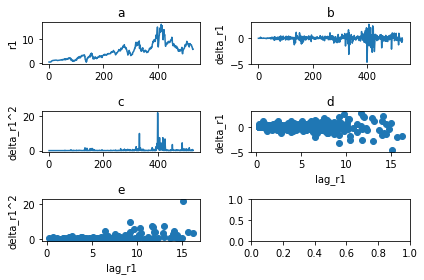

In [17]:
%matplotlib inline
#plot the figures
fig,axes=plt.subplots(3,2);
axe=axes.ravel()
axe[0].plot(r1)
axe[0].set_title('a')
axe[0].set_ylabel('r1')

axe[1].plot(delta_r1)
axe[1].set_title('b')
axe[1].set_ylabel('delta_r1')

axe[2].plot(delta_r1**2)
axe[2].set_title('c')
axe[2].set_ylabel('delta_r1^2')

axe[3].scatter(lag_r1,delta_r1)
axe[3].set_title('d')
axe[3].set_xlabel('lag_r1')
axe[3].set_ylabel('delta_r1')

axe[4].scatter(lag_r1,delta_r1**2)
axe[4].set_title('e')
axe[4].set_xlabel('lag_r1')
axe[4].set_ylabel('delta_r1^2')

fig.tight_layout()


In [31]:
#use scipy least square optimizer 

#define the function first
def fun(factor,delta1,lag1):
    return delta1-factor[0]*(factor[1]-lag1)

from scipy.optimize import leastsq
param,cov_x,infodict,mesg,ier=leastsq(fun,x0=(0.01,5),args=(delta_r1,lag_r1),full_output=True)

In [32]:
param

array([ 0.01983913,  5.32754118])

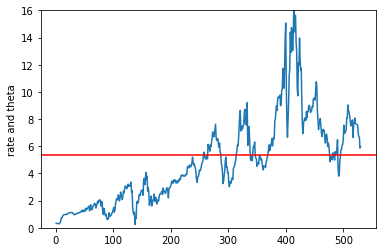

In [33]:
plt.plot(lag_r1)
plt.ylim((0,16))
plt.ylabel('rate and theta')
plt.axhline(y=param[1], hold=None,color='r')
plt.show()

In [45]:
#cov_x times error variance gives he variance covariance matrix
var_cov=cov_x*(infodict['fvec']**2).sum()/(len(delta_r1-2))
sd_a=np.sqrt(var_cov[0,0])
sd_theta=np.sqrt(var_cov[1,1])

In [48]:
#Problem 3
print("lower bond for a is {:.3f}".format(param[0]-2*sd_a))
print("upper bond for a is {:.3f}".format(param[0]+2*sd_a))
print("lower bond for theta is {:.3f}".format(param[1]-2*sd_theta))
print("upper bond for theta is {:.3f}".format(param[1]+2*sd_theta))

lower bond for a is 0.003
upper bond for a is 0.036
lower bond for theta is 2.653
upper bond for theta is 8.002


In [54]:
#The model provide the stimate for prameters of mu(r)=A(theta-lag_r)
# We then need to use the residual to estimate parameters in variance

#obtain the residual from previous model
res_sq=infodict['fvec']**2

#This time, we use curve_fit to run the same function

def func(lagr,A,B):
    return A*lagr**B

from scipy.optimize import curve_fit

popt, pcov = curve_fit(func, lag_r1, res_sq)

In [55]:
popt

array([  1.29977074e-03,   2.97322514e+00])

The above result is the same as obtained in R

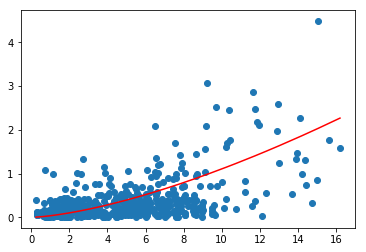

In [61]:
#plot the lag_r1 and 
plt.scatter(lag_r1,np.sqrt(res_sq));
plt.plot(sorted(lag_r1),np.sqrt(func(sorted(lag_r1),popt[0],popt[1])),color='r');

In [ ]:
#Problem 4 may not be very straight forward since we are not sure how the estimators sigma^2 and 2gamma are distributed

In [82]:
#Apply the weights to run the regression again

#Original book uses variance to adjust the weights

def func1(lagr,a,theta):
    return a*(theta-lagr)

nlmod_CKLS_wt_para1,nlmod_CKLS_wt_cov1=\
curve_fit(func1,\
          np.multiply(lag_r1,1/func(lag_r1,popt[0],popt[1])),\
          np.multiply(delta_r1,1/func(lag_r1,popt[0],popt[1])))

#Using standard derivation for different observation

nlmod_CKLS_wt_para2,nlmod_CKLS_wt_cov2=\
curve_fit(func1,\
          np.multiply(lag_r1,1/np.sqrt(func(lag_r1,popt[0],popt[1]))),\
          np.multiply(delta_r1,1/np.sqrt(func(lag_r1,popt[0],popt[1]))))



In [84]:
nlmod_CKLS_wt_para3,nlmod_CKLS_wt_cov3=\
curve_fit(func1,\
          lag_r1,\
          delta_r1,sigma=1/func(lag_r1,popt[0],popt[1]),absolute_sigma=True)

#Using standard derivation for different observation

nlmod_CKLS_wt_para4,nlmod_CKLS_wt_cov4=\
curve_fit(func1,\
          lag_r1,\
          delta_r1,sigma=1/np.sqrt(func(lag_r1,popt[0],popt[1])),absolute_sigma=True)



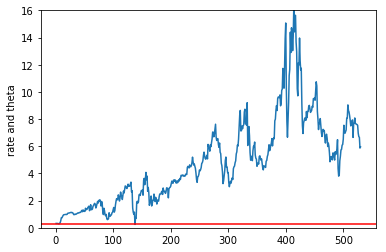

In [78]:
plt.plot(lag_r1)
plt.ylim((0,16))
plt.ylabel('rate and theta')
plt.axhline(y=nlmod_CKLS_wt_para2[1]/np.mean(1/np.sqrt(func(lag_r1,popt[0],popt[1]))), hold=None,color='r')
plt.show()

In [79]:
nlmod_CKLS_wt_para1/np.mean(1/func(lag_r1,popt[0],popt[1]))

array([-0.00089932,  0.30708457])

In [83]:
nlmod_CKLS_wt_para2/np.mean(1/np.sqrt(func(lag_r1,popt[0],popt[1])))

array([-0.02415569,  1.39119038])

In [85]:
nlmod_CKLS_wt_para3

array([  0.20484588,  10.16998749])

In [86]:
nlmod_CKLS_wt_para4

array([ 0.09752468,  7.98290653])